# Reading Libraries and Datasets

In [1]:
import pandas as pd
import os
import sweetviz as sv
import geopandas as gpd
from shapely import wkt
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import geodatasets
from geopy.geocoders import Nominatim
import warnings
import plotly.express as px
from geopy.geocoders import ArcGIS
import geopandas as gpd
import re
warnings.filterwarnings('ignore')

In [2]:
os.chdir('C:/Users/edwin/OneDrive/Escritorio/Personal files/Courses/Semester 2/Capstone Project/Databases')

In [3]:
directory_contents = os.listdir('.')
directory_contents

['db_filtered_NoNAs.csv',
 'db_filtered_wNAs.csv',
 'ODBus_v1.csv',
 'Other Databases',
 'sample.csv',
 'toronto data.csv',
 'toronto_df_locations.csv',
 'vancouver data.csv']

In [4]:
db=pd.read_csv("toronto data.csv")
db.head()

,_id,Category,Licence No.,Operating Name,Issued,Client Name,Business Phone,Business Phone Ext.,Licence Address Line 1,Licence Address Line 2,Licence Address Line 3,Conditions,Free Form Conditions Line 1,Free Form Conditions Line 2,Plate No.,Endorsements,Cancel Date,Last Record Update
0,1,PRIVATE TRANSPORTATION COMPANY,B02-4741962,TAXIFY,2018-01-18,TAXIFY CANADA INC,NaN,NaN,"35 OAK ST, #304","TORONTO, ON",M9N 1A1,TAXIFY;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,2018-12-07,2018-12-07
1,2,PRIVATE TRANSPORTATION COMPANY,B02-4728645,INSTARYDE,2017-09-08,INSTARYDE INC,NaN,NaN,425 ALNESS ST,"TORONTO, ON",M3J 2T8,INSTARYDE;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,2018-12-10,2019-05-06
2,3,PRIVATE TRANSPORTATION COMPANY,B02-4807677,DRIVEHER TRANSPORTATION,2018-03-08,DRIVEHER TRANSPORTATION INC,NaN,NaN,"100 DUNDAS ST E, #502","MISSISSAUGA, ON",L5A 1W5,DRIVEHER;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,2021-12-23,2021-12-23
3,4,PRIVATE TRANSPORTATION COMPANY,B02-4714142,RIDEIN,2017-05-18,RIDE INC,NaN,NaN,379 BERING AVE,"TORONTO, ON",M8Z 3B1,RIDEIN;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,2023-05-01,2023-06-07
4,5,PRIVATE TRANSPORTATION COMPANY,B02-5006733,CAPPTIN,2020-07-21,CAPPTIN TECHNOLOGIES (CND) INC,NaN,NaN,"4950 YONGE ST, #2200","TORONTO, ON",M2N 6K1,CAPPTIN;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,2023-05-01,2023-06-07


In [5]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154417 entries, 0 to 154416
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   _id                          154417 non-null  int64  
 1   Category                     154417 non-null  object 
 2   Licence No.                  154417 non-null  object 
 3   Operating Name               125679 non-null  object 
 4   Issued                       154417 non-null  object 
 5   Client Name                  154417 non-null  object 
 6   Business Phone               15966 non-null   float64
 7   Business Phone Ext.          1165 non-null    object 
 8   Licence Address Line 1       128911 non-null  object 
 9   Licence Address Line 2       128911 non-null  object 
 10  Licence Address Line 3       154377 non-null  object 
 11  Conditions                   77425 non-null   object 
 12  Free Form Conditions Line 1  43204 non-null   object 
 13 

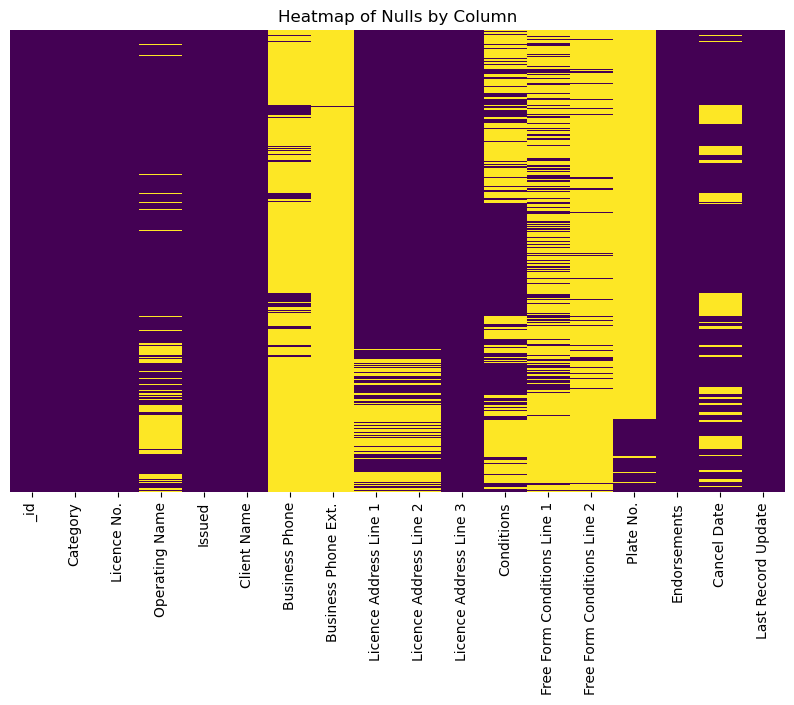

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(db.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of Nulls by Column')
plt.show()

# Cleaning Dataset

## Removing unnecessary columns

In [7]:
columns_todrop=["_id","Business Phone","Business Phone Ext."]

db.drop(columns=columns_todrop,inplace=True)

## Filtering to obtain food trucks dataset

Creating the column that concats Category, Endorsements and Conditions

In [8]:
db["filter_categories"]=db["Operating Name"].str.cat(db[["Category","Endorsements","Conditions"]],sep=" ",na_rep=" ")
db["filter_categories"]=db["filter_categories"].str.lower()

Applying filter

In [9]:
expressions=["refreshment vehicle","mobile vending","ice cream truck","food truck"]
mask = db['filter_categories'].str.contains('|'.join(expressions), case=False, na=False)
db_filtered = db[mask]

In [10]:
db_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3334 entries, 106084 to 154416
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Category                     3334 non-null   object
 1   Licence No.                  3334 non-null   object
 2   Operating Name               1507 non-null   object
 3   Issued                       3334 non-null   object
 4   Client Name                  3334 non-null   object
 5   Licence Address Line 1       1648 non-null   object
 6   Licence Address Line 2       1648 non-null   object
 7   Licence Address Line 3       3334 non-null   object
 8   Conditions                   2153 non-null   object
 9   Free Form Conditions Line 1  768 non-null    object
 10  Free Form Conditions Line 2  199 non-null    object
 11  Plate No.                    2465 non-null   object
 12  Endorsements                 3334 non-null   object
 13  Cancel Date               

## Getting latitude and longitude

### Creating address columnn

In [11]:
def row_cleaning(row):
    ad1=row['Licence Address Line 1']
    ad2=row['Licence Address Line 2']
    ad3=row['Licence Address Line 3']
    
    list_addresses=[ad1,ad2,'canada',ad3]
    filtered_addresses=[str(x).lower() for x in list_addresses if str(x).lower() !='nan']
    separator=','
    clean_row=separator.join(filtered_addresses)
    return clean_row

In [12]:
db_filtered['address'] = db_filtered.apply(lambda row:row_cleaning(row), axis=1)
db_filtered.drop(columns=['Licence Address Line 1','Licence Address Line 2','Licence Address Line 3','filter_categories'],inplace=True)
db_filtered.head()

,Category,Licence No.,Operating Name,Issued,Client Name,Conditions,Free Form Conditions Line 1,Free Form Conditions Line 2,Plate No.,Endorsements,Cancel Date,Last Record Update,address
106084,MOBILE VENDING (FOOD TRUCK),R54-4422459,NaN,2014-05-16,"AHMADZADEH-RAZAVI, MAHNAZ",NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-08-16,2015-08-16,"canada,l6p"
106085,MOBILE VENDING (FOOD TRUCK),R54-4422376,NaN,2014-05-15,TANG'S FAMILY RESTAURANT CORP,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-09-10,2015-09-10,"3380 midland ave, #19,toronto, on,canada,m1v 5b5"
106086,MOBILE VENDING (FOOD TRUCK),R54-4424708,NaN,2014-07-09,"INSRICHIENGMAI, SUSAN",NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-10-08,2015-10-08,"canada,m6k"
106087,MOBILE VENDING (FOOD TRUCK),R54-4422377,NaN,2014-05-15,1459949 ONTARIO INC,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2016-01-06,2016-01-06,"90 esna park dr, #22,markham, on,canada,l3r 2r7"
106088,MOBILE VENDING (FOOD TRUCK),R54-4422545,NaN,2014-05-20,2397349 ONTARIO INC,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2016-01-06,2016-01-06,"1621 skyline dr,mississauga, on,canada,l5e 2w9"


In [13]:
db_filtered.shape

(3334, 13)

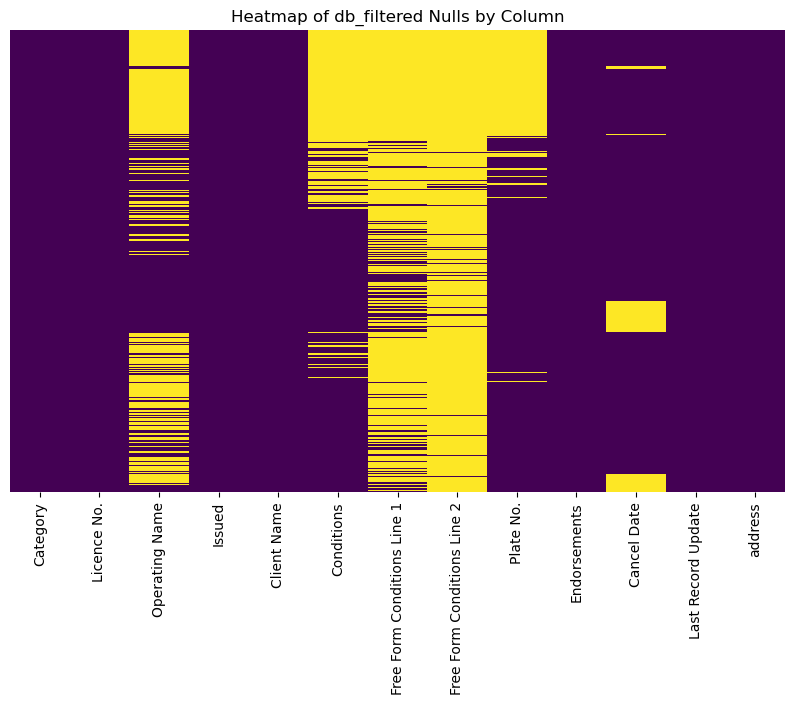

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(db_filtered.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of db_filtered Nulls by Column')
plt.show()

In [15]:
db_filtered.groupby(by=["Category", "Endorsements"]).count()["Licence No."]

Category                                 Endorsements                             
MOBILE VENDING (FOOD TRUCK)              MOBILE VENDING (FOOD TRUCK) 6-MONTH;         227
                                         MOBILE VENDING (FOOD TRUCK) 9-MONTH;          20
                                         MOBILE VENDING (FOOD TRUCK) ANNUAL;           33
MOBILE VENDING (ICE CREAM TRUCK)         MOBILE VENDING (ICE CREAM TRUCK) 6-MONTH;    433
                                         MOBILE VENDING (ICE CREAM TRUCK) 9-MONTH;     11
                                         MOBILE VENDING (ICE CREAM TRUCK) ANNUAL;      35
MOTORIZED REFRESHMENT VEHICLE OWNER      RV - MOTORIZED - ICE CREAM;                  410
                                         RV - MOTORIZED - NATURAL GAS HEATER;           3
                                         RV - MOTORIZED - NO HEATER;                   68
                                         RV - MOTORIZED - PROPANE HEATER;             939
NON-MOTORIZED REF

### Getting latitude and longitude from LODE

In [16]:
df_lode=pd.read_csv("ODBus_v1.csv")

In [17]:
df_lode.columns

Index(['idx', 'business_name', 'alt_business_name', 'business_sector',
       'business_subsector', 'business_description', 'business_id_no',
       'licence_number', 'licence_type', 'derived_NAICS',
       'source_NAICS_primary', 'source_NAICS_secondary', 'NAICS_descr',
       'NAICS_descr2', 'latitude', 'longitude', 'full_address', 'postal_code',
       'unit', 'street_no', 'street_name', 'street_direction', 'street_type',
       'city', 'prov_terr', 'total_no_employees', 'status', 'provider',
       'geo_source', 'CSDUID', 'CSDNAME', 'PRUID'],
      dtype='object')

In [18]:
df_cleaned_ld= df_lode[['licence_number','latitude','longitude']
                       ].replace("..",None).dropna(subset=['licence_number'])
df_cleaned_ld

,licence_number,latitude,longitude
108,B50-3082416,45.38223,-75.81674
109,B50-3616067,45.38223,-75.81674
110,B71-3113630,45.38223,-75.81674
111,B71-4180025,45.38223,-75.81674
112,B71-3008009,45.38223,-75.81674
...,...,...,...
446566,22-147123,None,None
446571,T37-3243965,None,None
446572,T37-4068651,None,None
446573,T94-0239626,None,None


In [19]:
db_filtered=pd.merge(db_filtered, df_cleaned_ld, how='left', left_on='Licence No.', right_on='licence_number')
db_filtered.head()

,Category,Licence No.,Operating Name,Issued,Client Name,Conditions,Free Form Conditions Line 1,Free Form Conditions Line 2,Plate No.,Endorsements,Cancel Date,Last Record Update,address,licence_number,latitude,longitude
0,MOBILE VENDING (FOOD TRUCK),R54-4422459,NaN,2014-05-16,"AHMADZADEH-RAZAVI, MAHNAZ",NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-08-16,2015-08-16,"canada,l6p",NaN,NaN,NaN
1,MOBILE VENDING (FOOD TRUCK),R54-4422376,NaN,2014-05-15,TANG'S FAMILY RESTAURANT CORP,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-09-10,2015-09-10,"3380 midland ave, #19,toronto, on,canada,m1v 5b5",NaN,NaN,NaN
2,MOBILE VENDING (FOOD TRUCK),R54-4424708,NaN,2014-07-09,"INSRICHIENGMAI, SUSAN",NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-10-08,2015-10-08,"canada,m6k",NaN,NaN,NaN
3,MOBILE VENDING (FOOD TRUCK),R54-4422377,NaN,2014-05-15,1459949 ONTARIO INC,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2016-01-06,2016-01-06,"90 esna park dr, #22,markham, on,canada,l3r 2r7",NaN,NaN,NaN
4,MOBILE VENDING (FOOD TRUCK),R54-4422545,NaN,2014-05-20,2397349 ONTARIO INC,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2016-01-06,2016-01-06,"1621 skyline dr,mississauga, on,canada,l5e 2w9",NaN,NaN,NaN


In [20]:
db_filtered.drop(columns=["licence_number"],inplace=True)

### Getting additional latitude and longitude

https://www.youtube.com/watch?v=EH8rmirTJ9U

In [21]:
#nom=ArcGIS()

In [22]:
#example=nom.geocode('3380 midland ave, #19,toronto, on,canada,m1v 5b5')

In [23]:
#example.address

In [24]:
def get_lat_lng(row):
    address=row["address"]
    try: 
        location=nom.geocode(address) 
        latitude=location.latitude
        longitude=location.longitude
        formatted_address=location.address
    except:
        location=None
        latitude=None
        longitude=None
        formatted_address=None
    return (latitude,longitude,formatted_address,location)

In [25]:
#db_filtered[['latitude', 'longitude','formatted_address','location']]=db_filtered.apply(lambda row:get_lat_lng(row),axis=1, result_type='expand')
#db_filtered.head()

In [26]:
#db_filtered.to_csv("toronto_df_locations.csv")
db_filtered=pd.read_csv("toronto_df_locations.csv")

In [27]:
db_filtered=db_filtered[db_filtered['formatted_address'].str.contains('Ontario')]
db_filtered.head()

,Unnamed: 0,Category,Licence No.,Operating Name,Issued,Client Name,Conditions,Free Form Conditions Line 1,Free Form Conditions Line 2,Plate No.,Endorsements,Cancel Date,Last Record Update,address,latitude,longitude,formatted_address,location
0,0,MOBILE VENDING (FOOD TRUCK),R54-4422459,NaN,2014-05-16,"AHMADZADEH-RAZAVI, MAHNAZ",NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-08-16,2015-08-16,"canada,l6p",43.794049,-79.702103,"L6P, Brampton, Ontario","L6P, Brampton, Ontario"
1,1,MOBILE VENDING (FOOD TRUCK),R54-4422376,NaN,2014-05-15,TANG'S FAMILY RESTAURANT CORP,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-09-10,2015-09-10,"3380 midland ave, #19,toronto, on,canada,m1v 5b5",43.809303,-79.290346,"3380 Midland Ave, Unit 19, Scarborough, Ontari...","3380 Midland Ave, Unit 19, Scarborough, Ontari..."
2,2,MOBILE VENDING (FOOD TRUCK),R54-4424708,NaN,2014-07-09,"INSRICHIENGMAI, SUSAN",NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-10-08,2015-10-08,"canada,m6k",43.637944,-79.429962,"M6K, Toronto, Ontario","M6K, Toronto, Ontario"
3,3,MOBILE VENDING (FOOD TRUCK),R54-4422377,NaN,2014-05-15,1459949 ONTARIO INC,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2016-01-06,2016-01-06,"90 esna park dr, #22,markham, on,canada,l3r 2r7",43.827610,-79.338622,"90 Esna Park Dr, Unit 22, Markham, Ontario, L3...","90 Esna Park Dr, Unit 22, Markham, Ontario, L3..."
4,4,MOBILE VENDING (FOOD TRUCK),R54-4422545,NaN,2014-05-20,2397349 ONTARIO INC,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2016-01-06,2016-01-06,"1621 skyline dr,mississauga, on,canada,l5e 2w9",43.599759,-79.558298,"1621 Skyline Dr, Mississauga, Ontario, L5E 2W9","1621 Skyline Dr, Mississauga, Ontario, L5E 2W9"


In [28]:
def extract_city(text):
    match = re.search(r'([^,]+),\s*Ontario', text)
    if match:
        return match.group(1).strip()
    else:
        return None

In [29]:
db_filtered['city']=db_filtered.apply(lambda row: extract_city(row["formatted_address"]), axis=1)
db_filtered.head()

,Unnamed: 0,Category,Licence No.,Operating Name,Issued,Client Name,Conditions,Free Form Conditions Line 1,Free Form Conditions Line 2,Plate No.,Endorsements,Cancel Date,Last Record Update,address,latitude,longitude,formatted_address,location,city
0,0,MOBILE VENDING (FOOD TRUCK),R54-4422459,NaN,2014-05-16,"AHMADZADEH-RAZAVI, MAHNAZ",NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-08-16,2015-08-16,"canada,l6p",43.794049,-79.702103,"L6P, Brampton, Ontario","L6P, Brampton, Ontario",Brampton
1,1,MOBILE VENDING (FOOD TRUCK),R54-4422376,NaN,2014-05-15,TANG'S FAMILY RESTAURANT CORP,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-09-10,2015-09-10,"3380 midland ave, #19,toronto, on,canada,m1v 5b5",43.809303,-79.290346,"3380 Midland Ave, Unit 19, Scarborough, Ontari...","3380 Midland Ave, Unit 19, Scarborough, Ontari...",Scarborough
2,2,MOBILE VENDING (FOOD TRUCK),R54-4424708,NaN,2014-07-09,"INSRICHIENGMAI, SUSAN",NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2015-10-08,2015-10-08,"canada,m6k",43.637944,-79.429962,"M6K, Toronto, Ontario","M6K, Toronto, Ontario",Toronto
3,3,MOBILE VENDING (FOOD TRUCK),R54-4422377,NaN,2014-05-15,1459949 ONTARIO INC,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2016-01-06,2016-01-06,"90 esna park dr, #22,markham, on,canada,l3r 2r7",43.827610,-79.338622,"90 Esna Park Dr, Unit 22, Markham, Ontario, L3...","90 Esna Park Dr, Unit 22, Markham, Ontario, L3...",Markham
4,4,MOBILE VENDING (FOOD TRUCK),R54-4422545,NaN,2014-05-20,2397349 ONTARIO INC,NaN,NaN,NaN,NaN,MOBILE VENDING (FOOD TRUCK) ANNUAL;,2016-01-06,2016-01-06,"1621 skyline dr,mississauga, on,canada,l5e 2w9",43.599759,-79.558298,"1621 Skyline Dr, Mississauga, Ontario, L5E 2W9","1621 Skyline Dr, Mississauga, Ontario, L5E 2W9",Mississauga


In [35]:
db_filtered.drop(columns=['Unnamed: 0','Plate No.'],inplace=True)
db_filtered.to_csv("dataframe_withlocations.csv")

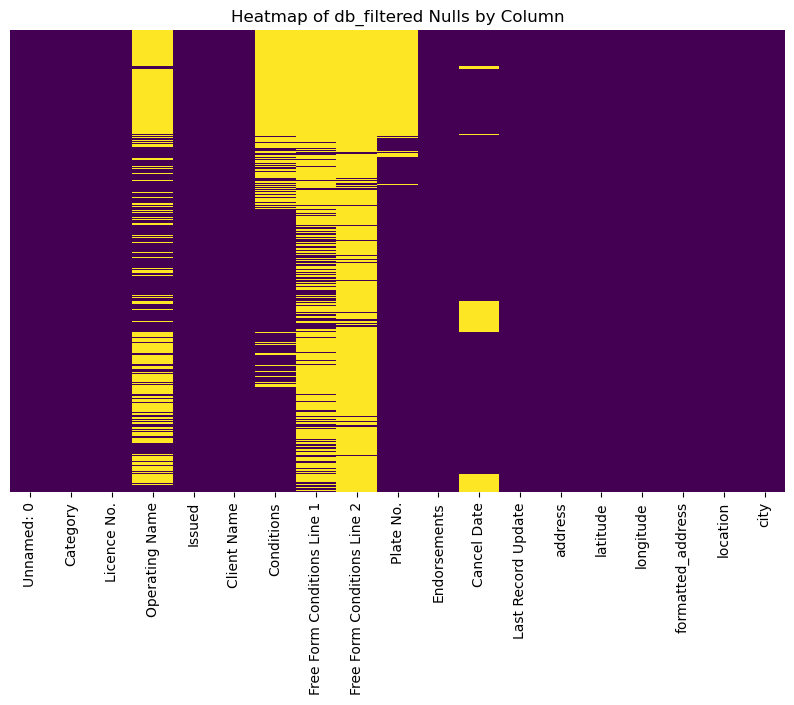

In [30]:
plt.figure(figsize=(10, 6))
sns.heatmap(db_filtered.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of db_filtered Nulls by Column')
plt.show()

In [31]:
# Create a map using Plotly Express
fig = px.scatter_mapbox(db_filtered, lat='latitude', lon='longitude',
                        hover_name='Operating Name',  # Changes what appears on hover
                        mapbox_style="open-street-map",  # or "carto-positron", "stamen-terrain", etc.
                        hover_data=['Licence No.', 'Issued', 'Cancel Date', 'address', 'Client Name'],
                        color='city',
                        zoom=5)  # Initial zoom level

fig.show()

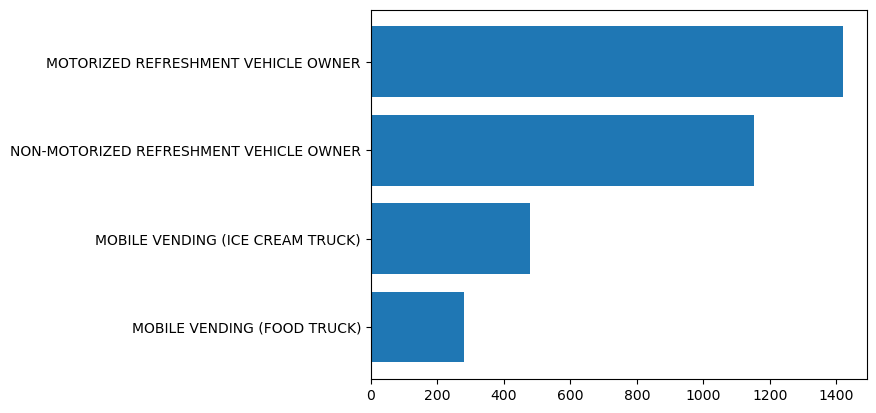

In [32]:
amount_category=db_filtered.groupby("Category").address.count().sort_values(ascending=True)
plt.barh(list(amount_category.index),list(amount_category.values))
plt.show()